In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Amazon
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [22]:
dataset = Amazon(root='data/Amazon', name='Computers')
data = dataset[0]

num_nodes = data.num_nodes

print("Informacje o grafie:")
print(data)
print(f"Liczba węzłów: {num_nodes}, liczba krawędzi: {data.num_edges}")
print(f"Liczba klas: {dataset.num_classes}")

Informacje o grafie:
Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])
Liczba węzłów: 13752, liczba krawędzi: 491722
Liczba klas: 10


In [23]:
torch.manual_seed(42)  
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_idx = torch.randperm(num_nodes)[:10000]  
train_mask[train_idx] = True
test_mask = ~train_mask

data.train_mask = train_mask
data.test_mask = test_mask

In [24]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

#pozdbiort do wizualizacji
subset_size = 1000  
subset_nodes = random.sample(range(num_nodes), subset_size)
G_subset = G.subgraph(subset_nodes)

#train/test
subset_train_nodes = [n for n in subset_nodes if train_mask[n]]
subset_test_nodes = [n for n in subset_nodes if test_mask[n]]
colors = data.y.cpu().numpy()
subset_colors = [colors[n] for n in subset_nodes]

pos_subset = nx.spring_layout(G_subset, seed=42)


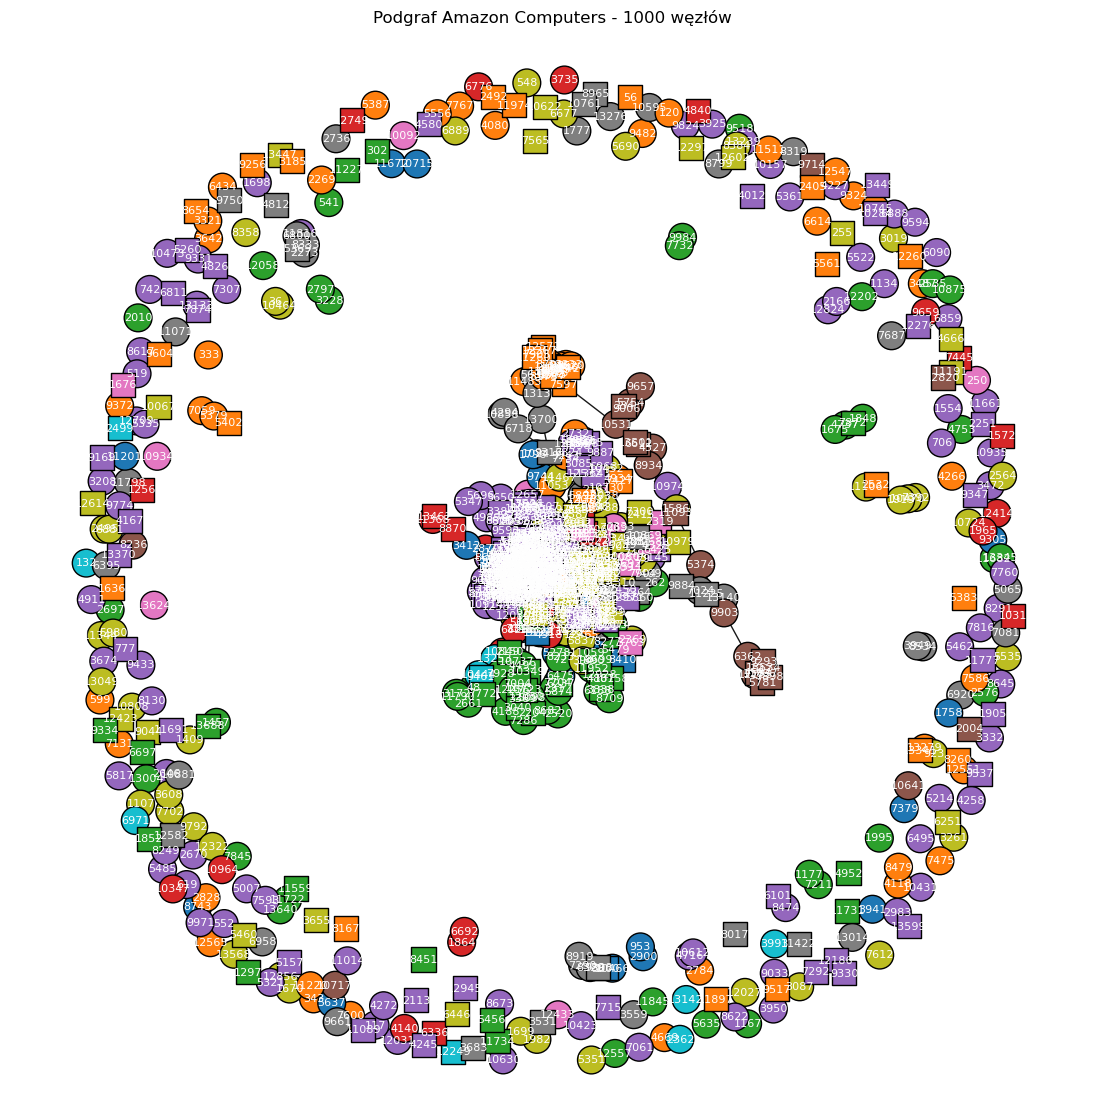

In [ ]:
plt.figure(figsize=(14,14))
plt.title(f"Podgraf Amazon Computers - {subset_size} węzłów")

nx.draw_networkx_edges(G_subset, pos_subset, alpha=0.9)


#train
nx.draw_networkx_nodes(G_subset, pos_subset,
                       nodelist=subset_train_nodes,
                       node_color=[colors[n] for n in subset_train_nodes],
                       cmap=plt.cm.tab10,
                       node_size=400,
                       edgecolors='k',
                       )

# test - kwadraty
nx.draw_networkx_nodes(G_subset, pos_subset,
                       nodelist=subset_test_nodes,
                       node_color=[colors[n] for n in subset_test_nodes],
                       cmap=plt.cm.tab10,
                       node_shape='s',
                       node_size=300,
                       edgecolors='k',)



nx.draw_networkx_labels(G_subset, pos_subset, font_color='white', font_size=8)
plt.axis('off')
plt.show()


In [38]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()

        # pierwsza warstwa
        self.convs.append(GCNConv(in_channels, hidden_channels))

        # warstwy ukryte
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # warstwa wyjściowa
        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)
        return x


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)


In [40]:
model = GNN(in_channels=dataset.num_features, hidden_channels=32, out_channels=dataset.num_classes, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")


Epoch 0, Loss: 2.2227, Test Acc: 0.0275
Epoch 10, Loss: 1.8073, Test Acc: 0.4379
Epoch 20, Loss: 1.4929, Test Acc: 0.6141
Epoch 30, Loss: 1.2672, Test Acc: 0.6429
Epoch 40, Loss: 1.0613, Test Acc: 0.6988
Epoch 50, Loss: 0.9026, Test Acc: 0.7513
Epoch 60, Loss: 0.8038, Test Acc: 0.7785
Epoch 70, Loss: 0.6988, Test Acc: 0.7729
Epoch 80, Loss: 0.6311, Test Acc: 0.8054
Epoch 90, Loss: 0.5767, Test Acc: 0.8177


In [41]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8289


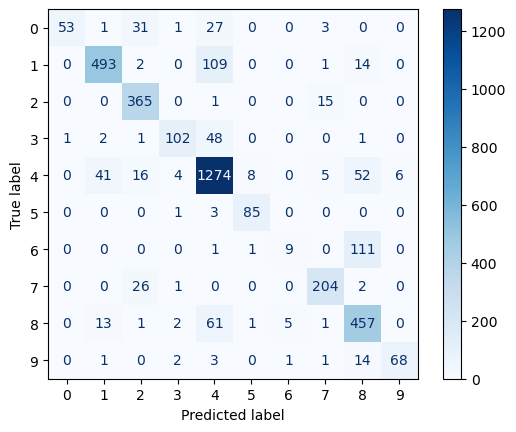

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_idx = data.test_mask.nonzero(as_tuple=True)[0].cpu()
cm = confusion_matrix(data.y[test_idx].cpu(), pred[test_idx].cpu())
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [43]:
def run_experiment(
    data,
    dataset,
    hidden_channels=32,
    num_layers=2,
    lr=0.01,
    epochs=100,
    device="cpu"
):
    model = GNN(
        in_channels=dataset.num_features,
        hidden_channels=hidden_channels,
        out_channels=dataset.num_classes,
        num_layers=num_layers
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    data = data.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_acc = (
            (pred[data.test_mask] == data.y[data.test_mask])
            .sum()
            .item()
            / data.test_mask.sum().item()
        )

    return {
        "hidden_channels": hidden_channels,
        "num_layers": num_layers,
        "lr": lr,
        "test_accuracy": test_acc
    }


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

experiments = []

learning_rates = [0.001, 0.005, 0.01]
hidden_sizes = [16, 32, 64]
num_layers_list = [2, 3]

for lr in learning_rates:
    for hidden in hidden_sizes:
        for layers in num_layers_list:
            result = run_experiment(
                data=data,
                dataset=dataset,
                hidden_channels=hidden,
                num_layers=layers,
                lr=lr,
                epochs=100,
                device=device
            )
            experiments.append(result)
            print(result)


{'hidden_channels': 16, 'num_layers': 2, 'lr': 0.001, 'test_accuracy': 0.6950959488272921}
{'hidden_channels': 16, 'num_layers': 3, 'lr': 0.001, 'test_accuracy': 0.7198827292110874}
{'hidden_channels': 32, 'num_layers': 2, 'lr': 0.001, 'test_accuracy': 0.8254264392324094}
{'hidden_channels': 32, 'num_layers': 3, 'lr': 0.001, 'test_accuracy': 0.7993070362473348}
{'hidden_channels': 64, 'num_layers': 2, 'lr': 0.001, 'test_accuracy': 0.8488805970149254}
{'hidden_channels': 64, 'num_layers': 3, 'lr': 0.001, 'test_accuracy': 0.8590085287846482}
{'hidden_channels': 16, 'num_layers': 2, 'lr': 0.005, 'test_accuracy': 0.8560767590618337}
{'hidden_channels': 16, 'num_layers': 3, 'lr': 0.005, 'test_accuracy': 0.8286247334754797}
{'hidden_channels': 32, 'num_layers': 2, 'lr': 0.005, 'test_accuracy': 0.8755330490405118}
{'hidden_channels': 32, 'num_layers': 3, 'lr': 0.005, 'test_accuracy': 0.8686034115138592}
{'hidden_channels': 64, 'num_layers': 2, 'lr': 0.005, 'test_accuracy': 0.875}
{'hidden_cha

In [45]:
import pandas as pd

df_results = pd.DataFrame(experiments)
df_results = df_results.sort_values(by="test_accuracy", ascending=False)

print(df_results)


    hidden_channels  num_layers     lr  test_accuracy
8                32           2  0.005       0.875533
10               64           2  0.005       0.875000
9                32           3  0.005       0.868603
17               64           3  0.010       0.864072
5                64           3  0.001       0.859009
11               64           3  0.005       0.856610
14               32           2  0.010       0.856343
6                16           2  0.005       0.856077
16               64           2  0.010       0.856077
15               32           3  0.010       0.851013
4                64           2  0.001       0.848881
7                16           3  0.005       0.828625
2                32           2  0.001       0.825426
13               16           3  0.010       0.802505
3                32           3  0.001       0.799307
1                16           3  0.001       0.719883
0                16           2  0.001       0.695096
12               16         